In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # scale [-1,1]
])

In [31]:
mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True,pin_memory=True,num_workers=2)

In [6]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

transforms.ToTensor() → converts PIL images (28×28 grayscale MNIST) to PyTorch tensors of shape [1, 28, 28] with values in [0,1].

transforms.Lambda(lambda x: (x - 0.5) * 2) → rescales [0,1] → [-1,1].
Why? Because neural nets train better when data is zero-centered.

torchvision.datasets.MNIST → downloads MNIST dataset.

DataLoader → batches data for training.

In [7]:
def get_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

torch.linspace(start, end, T) → makes T numbers evenly spaced between start and end.

This gives us βₜ values (noise variance per step).

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
T = 1000  # fewer steps to keep it light
betas = get_beta_schedule(T).to(device)
alphas = (1 - betas).to(device)
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

In [8]:
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
    xt = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return xt, noise


Take digit “5” at step t=50.
If sqrt_alphas_cumprod_t = 0.6 and sqrt_one_minus_alphas_cumprod_t = 0.8:

x_t = 0.6 * (clean digit) + 0.8 * (random noise)


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Time Embeddings (sinusoidal) ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        embeddings = torch.exp(
            torch.arange(half_dim, device=device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1))
        )
        embeddings = timesteps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings   # [B, dim]

# --- Residual Block with Time Conditioning ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)

        if in_channels != out_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.res_conv = nn.Identity()

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.norm1(h)
        h = h + self.time_mlp(t)[:, :, None, None]  # add time embedding
        h = F.relu(h)

        h = self.conv2(h)
        h = self.norm2(h)

        return F.relu(h + self.res_conv(x))

# --- U-Net for MNIST ---
class UNet(nn.Module):
    def __init__(self, img_channels=1, base_channels=32, time_dim=128):
        super().__init__()

        # Time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim*4),
            nn.ReLU(),
            nn.Linear(time_dim*4, time_dim)
        )

        # Encoder
        self.conv0 = ResidualBlock(img_channels, base_channels, time_dim)       # 1 -> 32
        self.down1 = ResidualBlock(base_channels, base_channels*2, time_dim)    # 32 -> 64

        # Bottleneck
        self.bot1 = ResidualBlock(base_channels*2, base_channels*2, time_dim)   # 64 -> 64

        # Decoder (fix here!)
        self.up1 = ResidualBlock(base_channels*2 + base_channels, base_channels, time_dim)  # 64+32=96 -> 32

        # Final conv
        self.conv_out = nn.Conv2d(base_channels, img_channels, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)

        # Down path
        x0 = self.conv0(x, t)                     # [B, 32, 28, 28]
        x1 = F.avg_pool2d(x0, 2)                  # [B, 32, 14, 14]
        x1 = self.down1(x1, t)                    # [B, 64, 14, 14]

        # Bottleneck
        b = self.bot1(x1, t)                      # [B, 64, 14, 14]

        # Up path
        u1 = F.interpolate(b, scale_factor=2, mode="nearest")   # [B, 64, 28, 28]
        u1 = self.up1(torch.cat([u1, x0], dim=1), t)            # concat → [B, 96, 28, 28]

        return self.conv_out(u1)                  # [B, 1, 28, 28]



In [42]:
# ------------------- 5. Training -------------------

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
device

'cuda'

In [49]:
epochs = 250  # keep very small for demo
start_epoch = 0
# If you want to resume training:
start_epoch, _ = load_checkpoint(model, optimizer)
for epoch in range(start_epoch,epochs):
    for x0, _ in dataloader:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.shape[0],), device=device)
        xt, noise = forward_diffusion(x0, t)
        pred_noise = model(xt, t)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(epoch+1, model, optimizer, loss.item())

🔄 Loaded checkpoint from epoch 150 with loss 0.0248


/tmp/ipykernel_728515/1844879604.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=device)


Epoch 151, Loss: 0.0192
Epoch 152, Loss: 0.0247
Epoch 153, Loss: 0.0216
Epoch 154, Loss: 0.0220
Epoch 155, Loss: 0.0280
✅ Saved checkpoint at epoch 155 -> ddpm_checkpoint.pth
Epoch 156, Loss: 0.0208
Epoch 157, Loss: 0.0232
Epoch 158, Loss: 0.0194
Epoch 159, Loss: 0.0272
Epoch 160, Loss: 0.0191
✅ Saved checkpoint at epoch 160 -> ddpm_checkpoint.pth
Epoch 161, Loss: 0.0206
Epoch 162, Loss: 0.0227
Epoch 163, Loss: 0.0225
Epoch 164, Loss: 0.0165
Epoch 165, Loss: 0.0247
✅ Saved checkpoint at epoch 165 -> ddpm_checkpoint.pth
Epoch 166, Loss: 0.0212
Epoch 167, Loss: 0.0215
Epoch 168, Loss: 0.0178
Epoch 169, Loss: 0.0225
Epoch 170, Loss: 0.0254
✅ Saved checkpoint at epoch 170 -> ddpm_checkpoint.pth
Epoch 171, Loss: 0.0258
Epoch 172, Loss: 0.0247
Epoch 173, Loss: 0.0204
Epoch 174, Loss: 0.0226
Epoch 175, Loss: 0.0171
✅ Saved checkpoint at epoch 175 -> ddpm_checkpoint.pth
Epoch 176, Loss: 0.0235
Epoch 177, Loss: 0.0185
Epoch 178, Loss: 0.0249
Epoch 179, Loss: 0.0215
Epoch 180, Loss: 0.0235
✅ Sav

In [18]:
@torch.no_grad()
def sample(model, T, shape):
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device).repeat(shape[0])
        pred_noise = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        beta = betas[t]
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise)
        if t > 0:
            x += torch.sqrt(beta) * torch.randn_like(x)
    return x


In [20]:
def save_checkpoint(epoch, model, optimizer, loss, filename="ddpm_checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(checkpoint, filename)
    print(f"✅ Saved checkpoint at epoch {epoch} -> {filename}")

In [22]:
def load_checkpoint(model, optimizer, filename="ddpm_checkpoint.pth"):
    if not os.path.isfile(filename):
        print(f"⚠️ No checkpoint found at {filename}, starting from scratch...")
        return 0, 0.0  # epoch=0, loss=0

    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"🔄 Loaded checkpoint from epoch {epoch} with loss {loss:.4f}")
    return epoch, loss


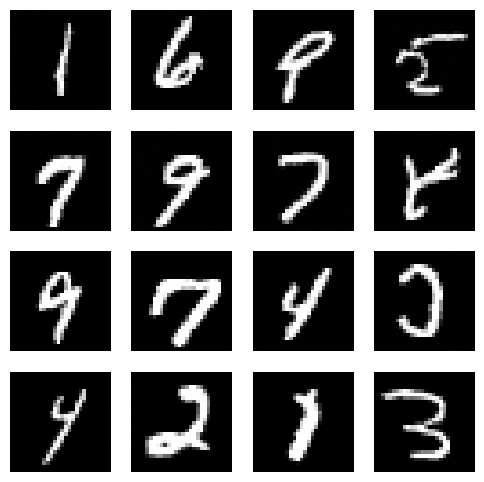

In [50]:
# ------------------- 7. Generate Samples -------------------
samples = sample(model, T, (16, 1, 28, 28)).cpu()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow((samples[i].squeeze() + 1) / 2, cmap="gray")  # scale back to [0,1]
    ax.axis("off")
plt.show()